In [11]:
import ot
import matplotlib.pyplot as plt
import torch
from torch import Tensor
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from torchmetrics.functional import pairwise_cosine_similarity
# from networks import make_resnet, CONFIGS
from efficientnet import EfficientNet
from train import make_data

In [2]:
TEACHER = "resnet110"
STUDENT = "resnet18"

In [6]:
teacher_log = torch.load(f"./logs/effnetb0_cifar100_strong_augment.pt")

In [4]:
teacher_log = torch.load(f"./logs/{TEACHER}_cifar100.pt")
student_log = torch.load(f"./logs/{STUDENT}_cifar100.pt")

___
# 1. Plot training log 

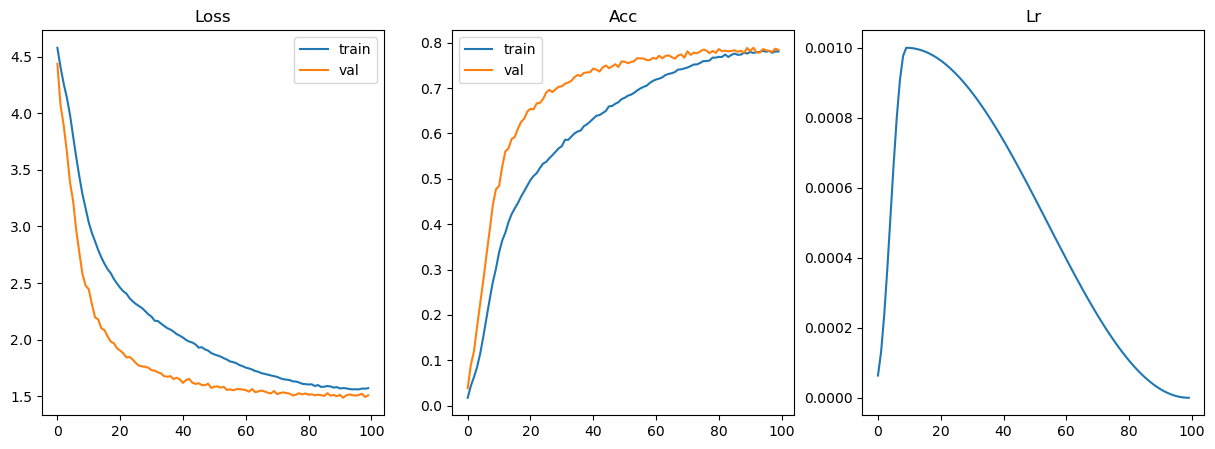

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(teacher_log["state"]["train"]["loss"], label="train")
ax[0].plot(teacher_log["state"]["val"]["loss"], label="val")
ax[1].plot(teacher_log["state"]["train"]["acc"], label="train")
ax[1].plot(teacher_log["state"]["val"]["acc"], label="val")
ax[2].plot(teacher_log["state"]["lr"])
ax[0].set_title("Loss")
ax[1].set_title("Acc")
ax[0].legend()
ax[1].legend()
ax[2].set_title("Lr")
plt.show()

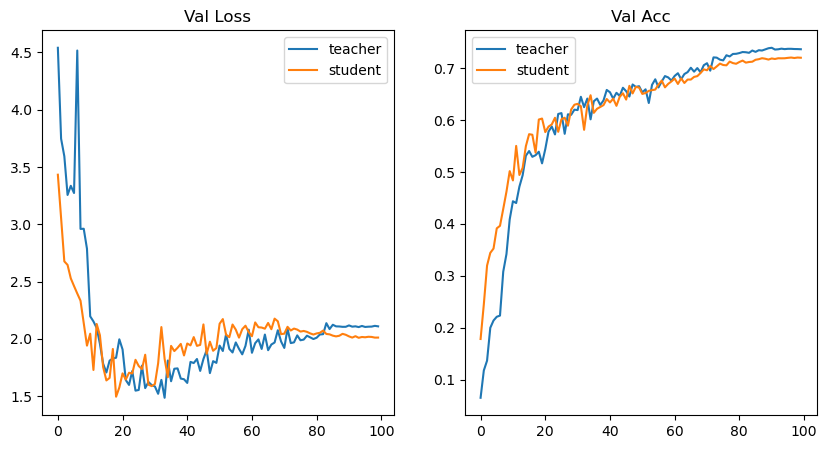

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(teacher_log["state"]["val"]["loss"], label="teacher")
ax[0].plot(student_log["state"]["val"]["loss"], label="student")
ax[1].plot(teacher_log["state"]["val"]["acc"], label="teacher")
ax[1].plot(student_log["state"]["val"]["acc"], label="student")
ax[0].set_title("Val Loss")
ax[1].set_title("Val Acc")
ax[0].legend()
ax[1].legend()
plt.show()

___
# 2. Get features

In [8]:
def freeze(module: torch.nn.Module) -> None:
    for p in module.parameters():
        p.requires_grad_(False)

In [9]:
data = make_data(dataset="cifar100", rootdir="/data/Datasets/cifar100/", batch_size=8)

In [10]:
X, y = next(iter(data.val_loader))

In [12]:
teacher = EfficientNet.from_name("efficientnet-b0").cuda()
teacher.load_state_dict(teacher_log["network"])

<All keys matched successfully>

In [11]:
# teacher, output_dim = make_resnet(TEACHER, first_feature_maps=64, large=False)
# student, output_dim = make_resnet(STUDENT, first_feature_maps=64, large=False)

In [13]:
print(f"{teacher.num_params:,}")
# print(f"{student.num_params:,}")

4,135,648


In [14]:
# teacher.load_state_dict(teacher_log["backbone"])
# student.load_state_dict(student_log["backbone"])

In [15]:
freeze(teacher)

In [18]:
features_teacher = teacher.extract_features(X.cuda(), return_all_features=True)
# features_student = student(X, return_all_features=True)

In [19]:
print(len(features_teacher))
# print(len(features_student))

9


In [20]:
for f in features_teacher:
    print(f.shape)

torch.Size([8, 32, 16, 16])
torch.Size([8, 16, 16, 16])
torch.Size([8, 24, 8, 8])
torch.Size([8, 40, 4, 4])
torch.Size([8, 80, 2, 2])
torch.Size([8, 112, 2, 2])
torch.Size([8, 192, 1, 1])
torch.Size([8, 320, 1, 1])
torch.Size([8, 1280])


In [21]:
# def get_last_layer_features(arch: str, features: list[Tensor]) -> list[Tensor]:
#     """ ResNet is composed of layers: each layer is a stack of blocks.
#         ResNet returns a flatten list of features but we actually want the features from
#         the last block of each layer.
#     """
#     layer_depths = [layer_params[0] for layer_params in CONFIGS["params"][arch]]
#     running_idx = 0
#     features_indices = [0]
#     for d in layer_depths:
#         running_idx += d
#         features_indices.append(running_idx)
#     return [features[idx] for idx in features_indices]

In [22]:
# features_teacher = get_last_layer_features(TEACHER, features_teacher)
# features_student = get_last_layer_features(STUDENT, features_student)

In [23]:
# table = PrettyTable(["Layer", "Teacher", "Student"])
# for i, (ft, fs) in enumerate(zip(features_teacher, features_student)):
#     table.add_row([f"layer {i+1}", list(ft.shape[1:]), list(fs.shape[1:])])
# print(table)

# 3. Make graph from features

In [27]:
def get_intra_similarity_matrices(features: list[Tensor]) -> list[Tensor]:
    " list (layer) of lists (batch elements) of sim matrices (feature maps)."
    sim_matrices = list()
    for layer_features in features:  # (l, b, c, h, w) ->  (b, c, h, w)
        layer_sim_matrices = list()
        for element_features in layer_features:  # (b, c, h, w) -> (c, h, w) 
            x = element_features.flatten(start_dim=1)  # (c, h, w) - > (c, h * w)
            print(x.shape)
            break
            sim_matrix = pairwise_cosine_similarity(x)  # (c, c)
            sim_matrix /= sim_matrix.max()
            layer_sim_matrices.append(sim_matrix)
        layer_sim_matrices = torch.stack(layer_sim_matrices)
        sim_matrices.append(layer_sim_matrices)
    return sim_matrices

In [28]:
# #TODO: pas fonctionnel, il faut réflechir à ça; mais c'est probablement pas utile en vrai
# def get_inter_similarity_matrices(source_features: Tensor, target_features) -> list[list[Tensor]]:
#     " list (layer) of lists (batch elements) of sim matrices."
#     sim_matrices = list()
#     for source_layer_features, target_layer_features in zip(source_features, target_features):  # (l, b, c, h, w) ->  (b, c, h, w)
#         layer_sim_matrices = list()
#         for source_element_features, target_element_features in zip(source_layer_features, target_layer_features):  # (b, c, h, w) -> (c, h, w) 
#             x = element_features.flatten(start_dim=1)  # (c, h, w) - > (c, h * w)
#             c = x.size(0)
#             sim_matrix = pairwise_cosine_similarity(x, x)  # (c, c)
#             layer_sim_matrices.append(sim_matrix)
#         sim_matrices.append(layer_sim_matrices)
#     return sim_matrices

In [29]:
sim_matrices_teacher = get_intra_similarity_matrices(features_teacher)
# sim_matrices_student = get_intra_similarity_matrices(features_student)

UnboundLocalError: local variable 'x' referenced before assignment

In [142]:
imshow_kwargs = dict(vmin=0, vmax=1, cmap='jet')

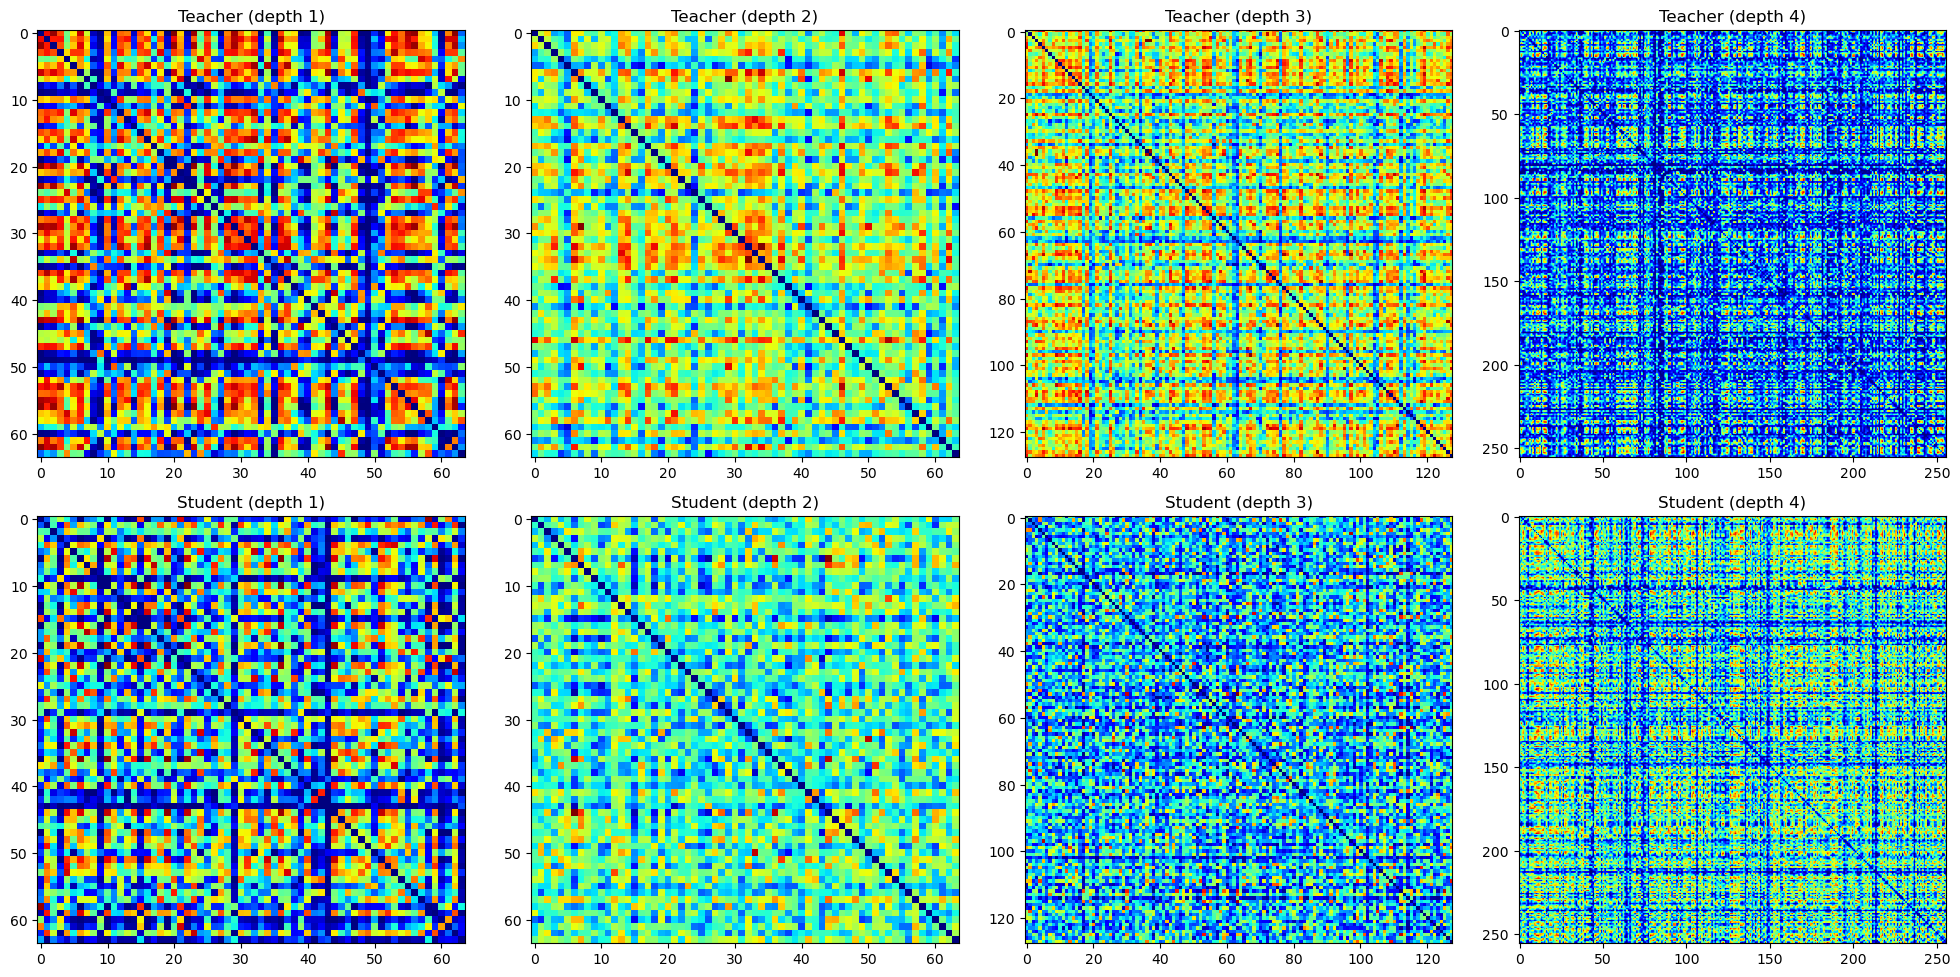

In [143]:
fig, ax = plt.subplots(2, 4, figsize=(5 * 4, 5 * 2))
for i, (f_t, f_s) in enumerate(zip(sim_matrices_teacher, sim_matrices_student)):
    ax[0][i].imshow(f_t[0].detach().cpu().numpy(), **imshow_kwargs)
    ax[1][i].imshow(f_s[0].detach().cpu().numpy(), **imshow_kwargs)
    ax[0][i].set_title(f"Teacher (depth {i+1})")
    ax[1][i].set_title(f"Student (depth {i+1})")
plt.tight_layout(pad=2)
plt.show()

- le teacher a l'air un peu plus structuré
- dans les dernières couches y'a vraiment des blocs qui apparaissent, et qui sont organisés similairement pour teacher et student

In [144]:
def make_knn_graph(similary_matrix: Tensor, k: int = None) -> torch.Tensor:
    c = similary_matrix.size(0)
    if k is None:
        k = c // 8
    knn = similary_matrix.topk(k=k)
    adjacency = torch.zeros(c, c)
    adjacency[torch.arange(c).repeat_interleave(k), knn.indices.flatten()] = knn.values.flatten()
    return adjacency

In [145]:
def make_epsilon_graph(similary_matrix: Tensor, eps: int = None):
    adjacency = similary_matrix.clone()
    if eps is None:
        # do something clever to infer a good value
        eps = similary_matrix.mean()
    adjacency[adjacency < eps] = 0
    return adjacency

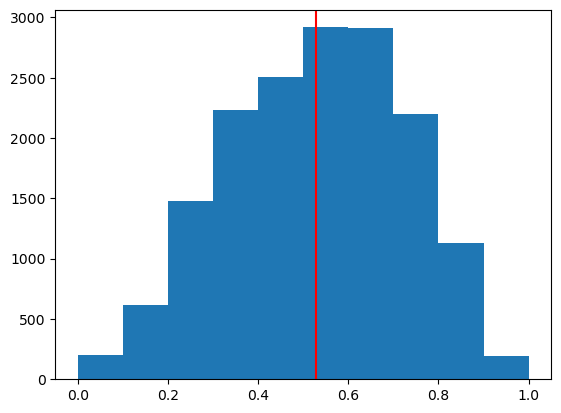

In [146]:
NON_ZERO = False

data = sim_matrices_teacher[2][0].flatten().detach().cpu()
data = data.nonzero().numpy() if NON_ZERO else data
plt.hist(data)
plt.axvline(data.mean(), c="red")
plt.show()

In [62]:
BATCH_IDX = 0

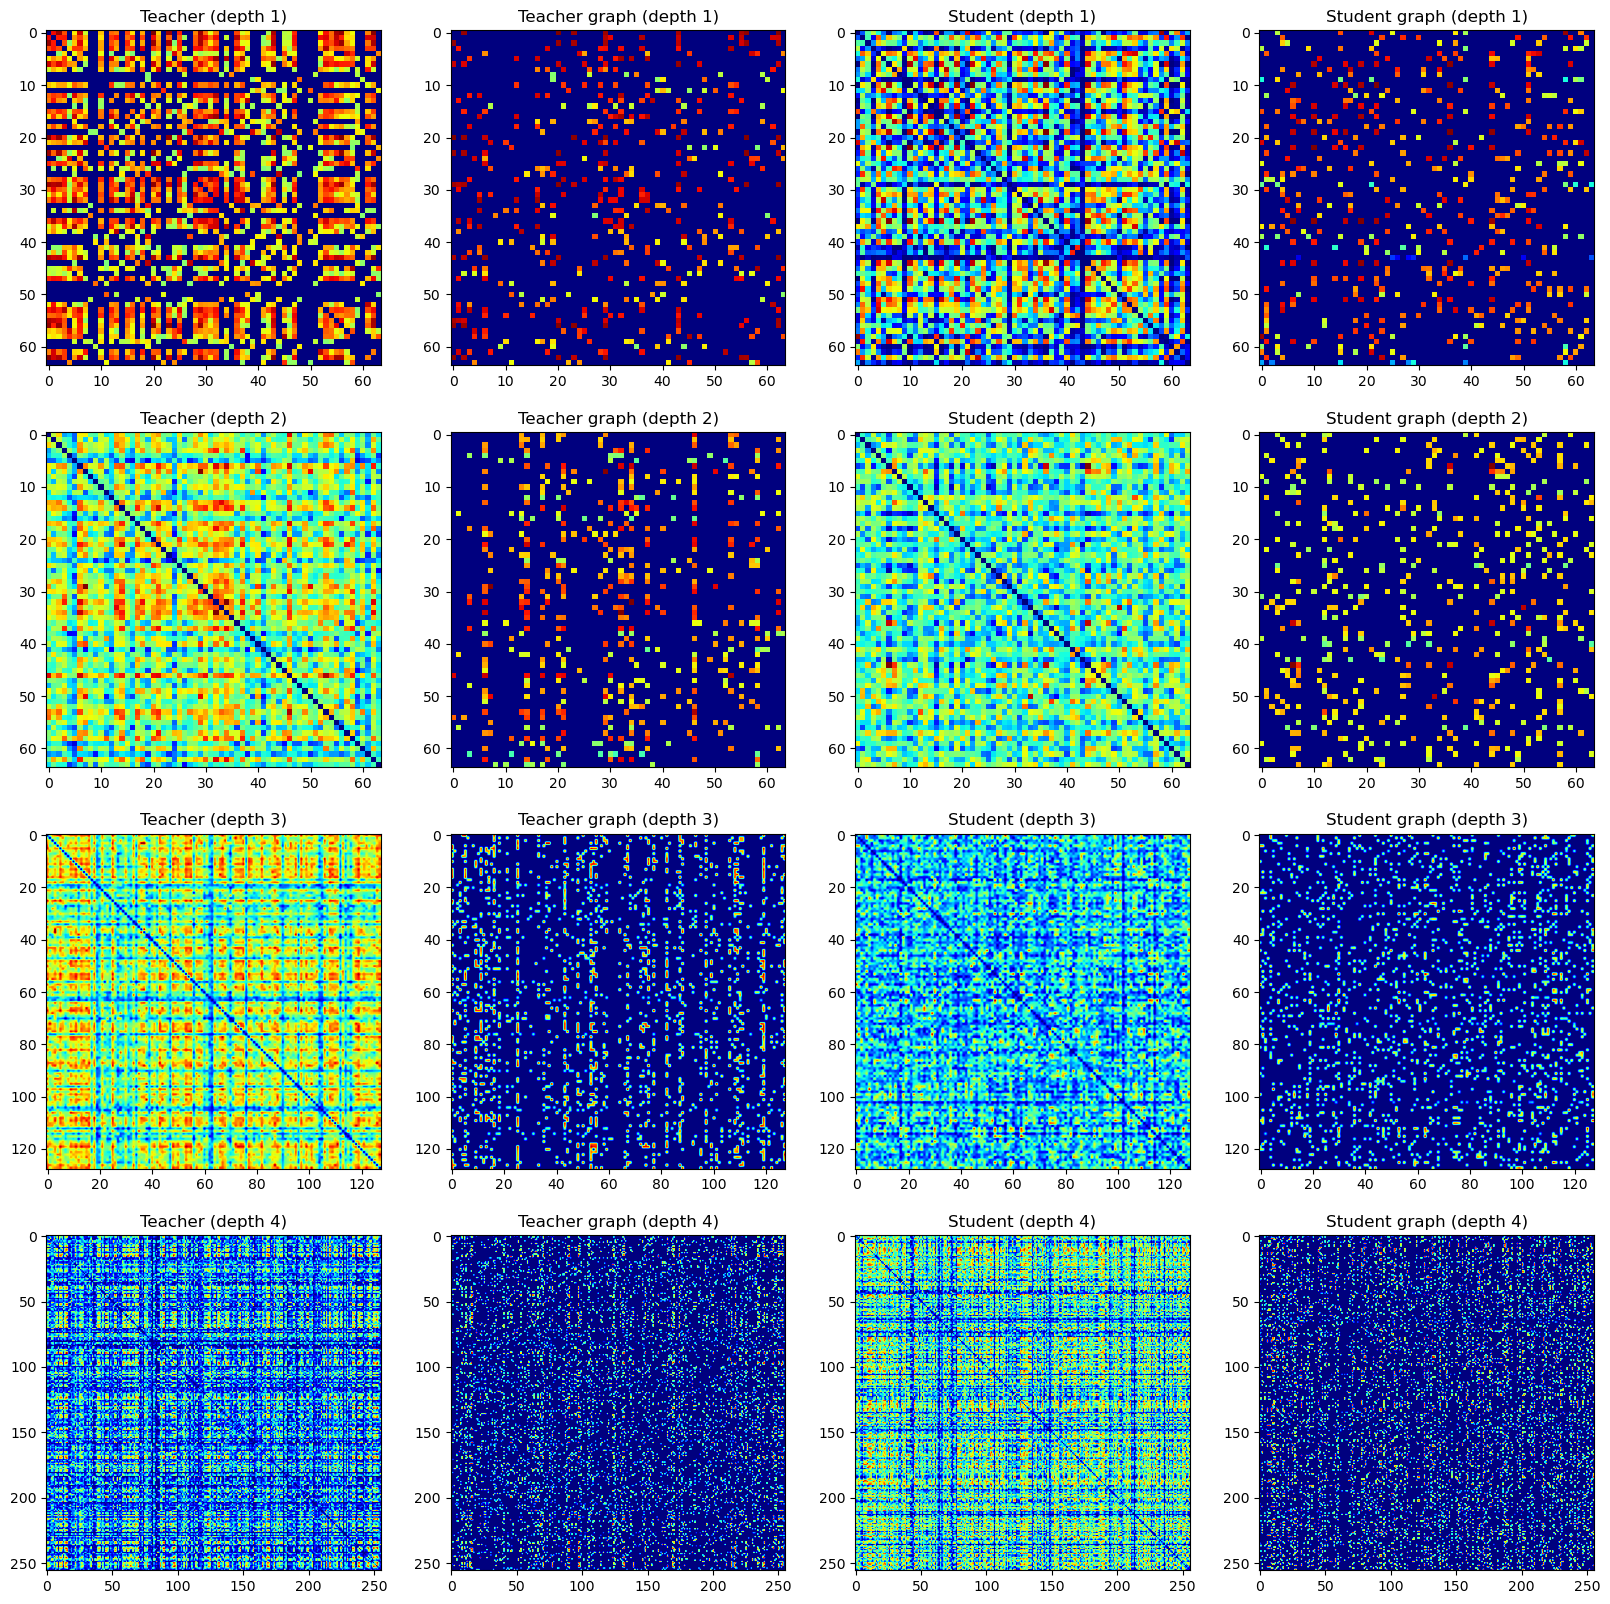

In [63]:
imshow_kwargs = dict(vmin=0, vmax=1, cmap='jet')
fig, ax = plt.subplots(4, 4, figsize=(5 * 4, 5 * 4))
for i, (f_t, f_s) in enumerate(zip(sim_matrices_teacher, sim_matrices_student)):

    f_t_i = f_t[BATCH_IDX].detach().cpu()
    f_s_i = f_s[BATCH_IDX].detach().cpu()

    f_t_i_graph = make_knn_graph(f_t_i)
    f_s_i_graph = make_knn_graph(f_s_i)
    
    ax[i][0].imshow(f_t_i, **imshow_kwargs)
    ax[i][1].imshow(f_t_i_graph, **imshow_kwargs)

    ax[i][2].imshow(f_s_i, **imshow_kwargs)
    ax[i][3].imshow(f_s_i_graph, **imshow_kwargs)
    
    ax[i][0].set_title(f"Teacher (depth {i+1})")
    ax[i][1].set_title(f"Teacher graph (depth {i+1})")
    ax[i][2].set_title(f"Student (depth {i+1})")
    ax[i][3].set_title(f"Student graph (depth {i+1})")

plt.show()

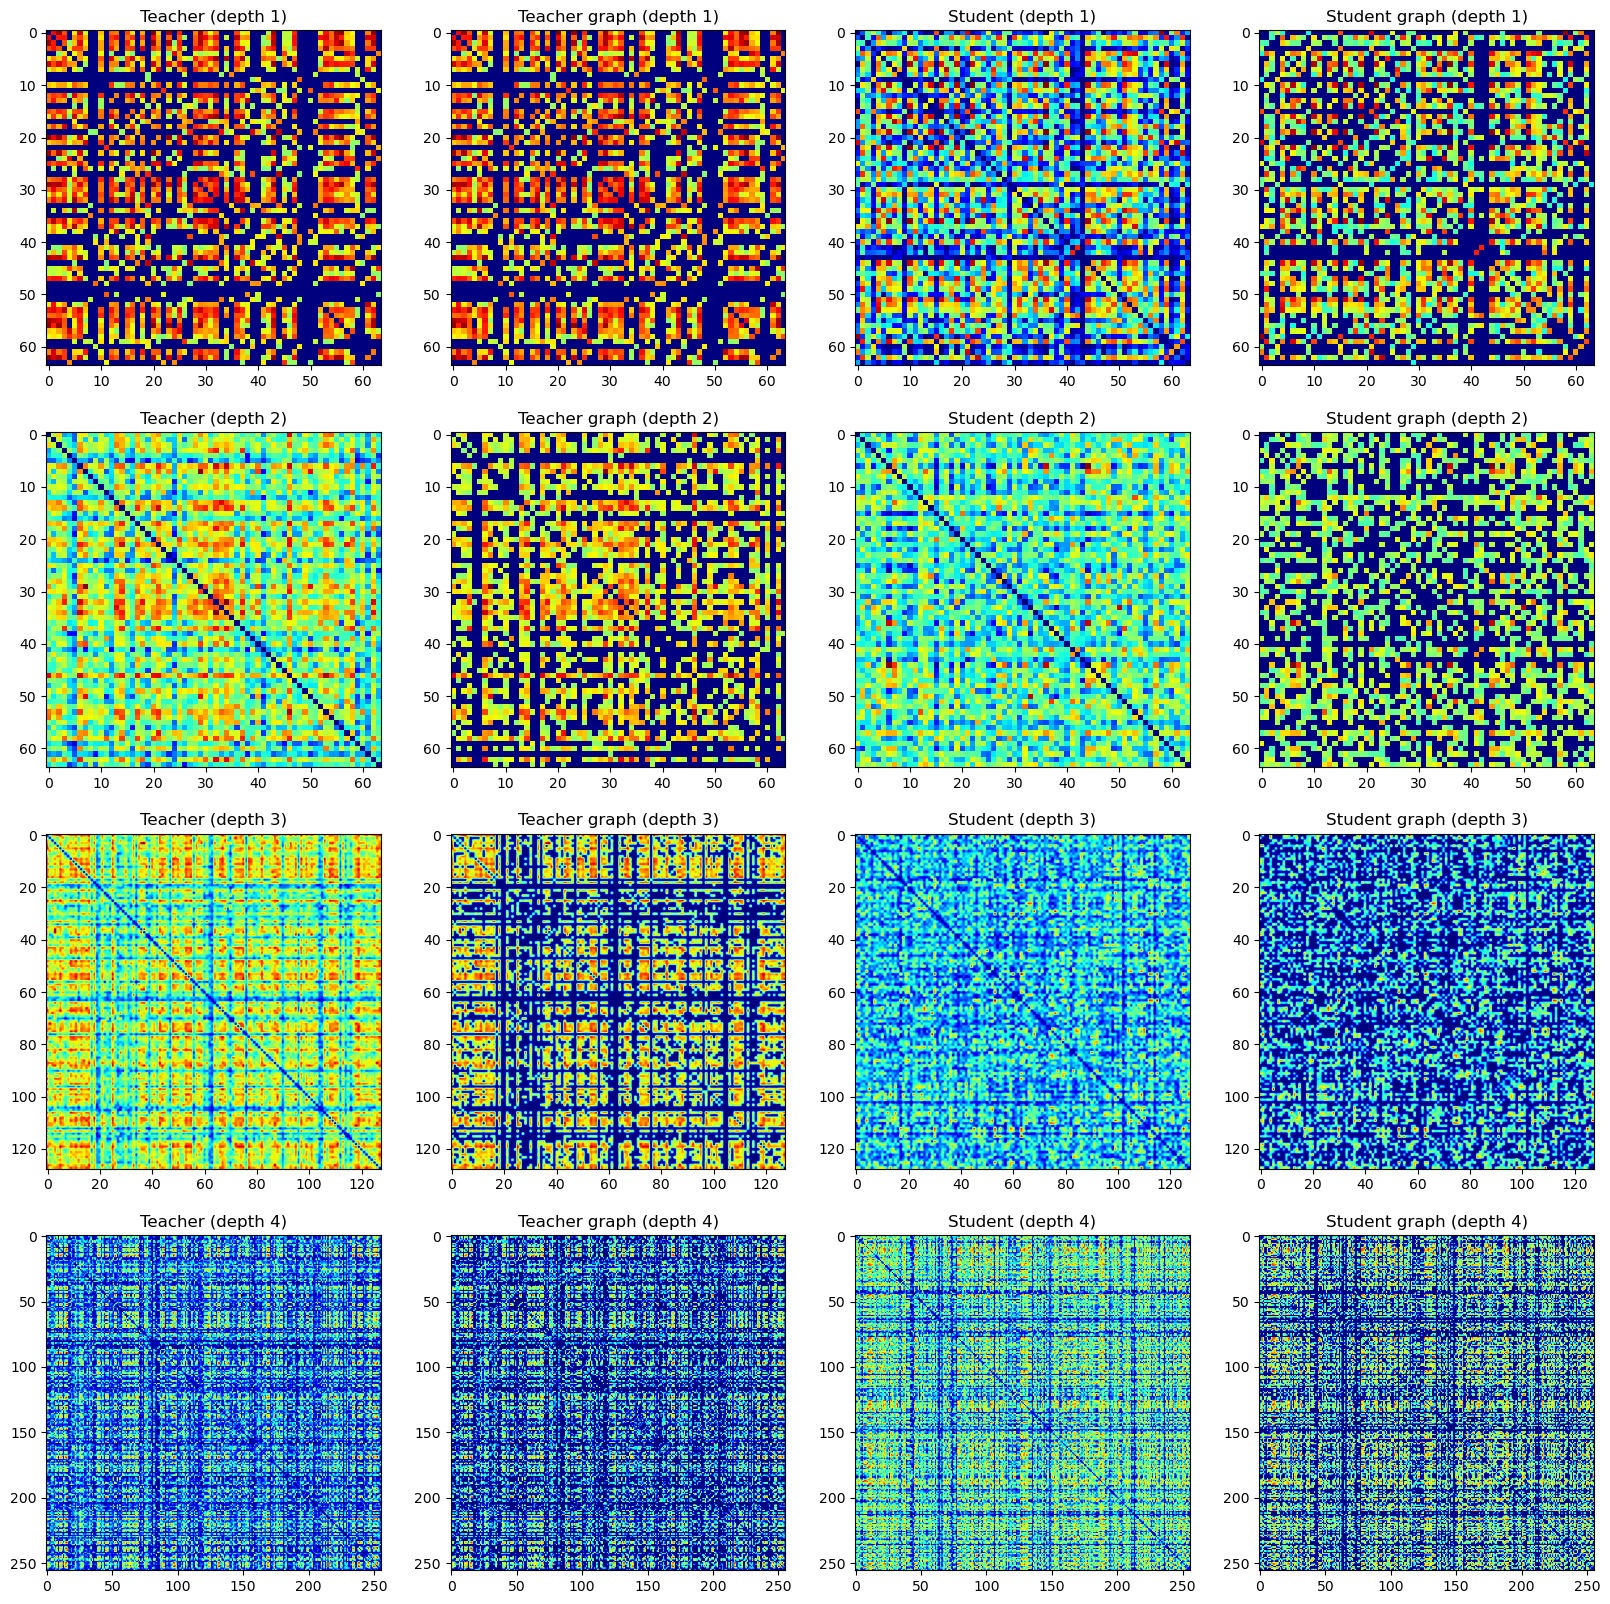

In [64]:
imshow_kwargs = dict(vmin=0, vmax=1, cmap='jet')
fig, ax = plt.subplots(4, 4, figsize=(5 * 4, 5 * 4))
for i, (f_t, f_s) in enumerate(zip(sim_matrices_teacher, sim_matrices_student)):

    f_t_i = f_t[BATCH_IDX].detach().cpu()
    f_s_i = f_s[BATCH_IDX].detach().cpu()

    f_t_i_graph = make_epsilon_graph(f_t_i)
    f_s_i_graph = make_epsilon_graph(f_s_i)
    
    ax[i][0].imshow(f_t_i, **imshow_kwargs)
    ax[i][1].imshow(f_t_i_graph, **imshow_kwargs)

    ax[i][2].imshow(f_s_i, **imshow_kwargs)
    ax[i][3].imshow(f_s_i_graph, **imshow_kwargs)
    
    ax[i][0].set_title(f"Teacher (depth {i+1})")
    ax[i][1].set_title(f"Teacher graph (depth {i+1})")
    ax[i][2].set_title(f"Student (depth {i+1})")
    ax[i][3].set_title(f"Student graph (depth {i+1})")

plt.show()

In [147]:
def normalize_graph(adjacency: Tensor) -> Tensor:
    degrees = (f_t_i_graph > 0).sum(dim=0)  # number of edges
    D = torch.diag(degrees ** (-1/2))
    return D @ f_t_i_graph @ D

In [148]:
LAYER_IDX = 0
BATCH_IDX = 0
f_t_i = sim_matrices_teacher[LAYER_IDX][BATCH_IDX].detach().cpu()
# f_t_i_graph = make_epsilon_graph(f_t_i)
f_t_i_graph = make_knn_graph(f_t_i)
normalized_graph = normalize_graph(f_t_i_graph)

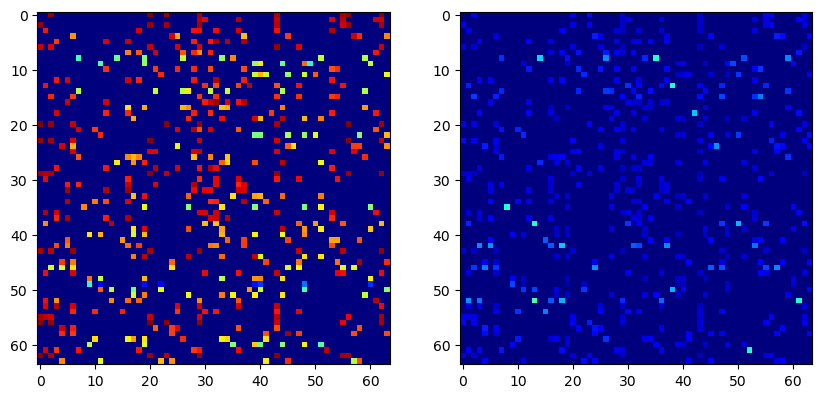

In [149]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(f_t_i_graph, **imshow_kwargs)
ax[1].imshow(normalized_graph, **imshow_kwargs)
plt.show()

___
# 4. Compute Gromov - Wasserstein

In [150]:
batch_size = X.size(0)

In [153]:
KNN = True

graph_fn = make_knn_graph if KNN else make_epsilon_graph

losses = list()
for layer_sim_t, layer_sim_s in zip(sim_matrices_teacher, sim_matrices_student):
    layer_loss = 0
    for elem_sim_t, elem_sim_s in zip(layer_sim_t, layer_sim_s):
        # choix de p et q à réfléchir
        p = ot.unif(len(elem_sim_t), type_as=elem_sim_t)
        q = ot.unif(len(elem_sim_s), type_as=elem_sim_s)
        graph_t = graph_fn(elem_sim_t)
        graph_s = graph_fn(elem_sim_s)
        layer_loss += ot.gromov.gromov_wasserstein2(graph_t, graph_s, p, q, 'square_loss')
    losses.append(layer_loss)

/data/mambaforge/envs/dlgpu/lib/python3.10/site-packages/ot/lp/__init__.py:343: UserWarning: Problem unbounded
  result_code_string = check_result(result_code)


In [152]:
losses

[tensor(nan, grad_fn=<AddBackward0>),
 tensor(0.7002, grad_fn=<AddBackward0>),
 tensor(0.9152, grad_fn=<AddBackward0>),
 tensor(nan, grad_fn=<AddBackward0>)]

Il y a des NaN mais je fais un peu n'importe comment ce calcul de loss donc pas étonnant. 
En tout cas ça fait un embryon de code fonctionnel: on a bien une Gromov-Wasserstein différentiable entre des graphes de features du student et du teacher (frozen). 